#### **Evaluating the relationship between the BrainAgeGap (BAG) and the cognitive/behavioral profiles**

In [1]:
# Imports
from itertools import product
import os
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from tqdm import tqdm

from neurostatx.statistics.models import plsr_cv, permutation_testing

In [2]:
# Setting up data and output paths.
repository_dir = "~/code/Gagnon_BrainAge_2025/"
data_abcd = "/Volumes/T7/BrainProfilesAssociations/ABCD/"
output_folder = "/Volumes/T7/BrainAgeStudy/"

# Create output folder if it doesn't exist.
output_dir = f"{output_folder}/BAG-Profiles/"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Set Harding font.
plt.rcParams['font.family'] = 'Harding Text Web'

# Set the Set2 color palette as an iterable.
cmap = sns.color_palette("Set2", 8)

In [100]:
# Load dataset.
df = pd.read_csv(f"{output_folder}/BAG_df.csv")

# Load the profiles' dataset.
fcm = pd.read_excel(f"{output_folder}/merged_fcm_data.xlsx")

# remove the "_" from the subjectkey column and append "sub-".
fcm["subjectkey"] = "sub-" + fcm["subjectkey"].str.replace("_", "")
fcm.rename(columns={"subjectkey": "sid"}, inplace=True)

regions = ["BAG_WholeBrain", "BAG_Frontal", "BAG_Temporal", "BAG_Parietal",
           "BAG_Occipital", "BAG_Subcortical", "BAG_Limbic", "BAG_Insula"]
profiles = ["Cluster #1", "Cluster #2", "Cluster #3", "Cluster #4"]

# Keep only the sid, and Cluster columns.
fcm = fcm[["sid"] + profiles]

# Merge on sid
df = df.merge(fcm, on="sid", how="left")

# Print the number of subjects in the merged df.
print(f"Number of subjects in merged df: {df['sid'].nunique()}")
# Drop rows with missing values, only in the fcm columns.
df.dropna(subset=profiles, inplace=True)
# Print the new number of subjects.
print(f"Number of subjects after dropping missing values: {df['sid'].nunique()}")

# Dummy code the sites to a integer.
df["site"] = df["site"].astype("category").cat.codes

# Regress out the covariates.
for i, region in tqdm(enumerate(regions), desc="Regressing out covariates"):

    # Run a linear model and fetch the residuals.
    mod = OLS(
        df[region + "_Corrected"].values,
        sm.add_constant(df[["age", "sex", "income_groups", "edu_groups", "Ethnicity", "handedness"]]),
    ).fit()

    df[region + "_residuals"] = scale(mod.resid)

# Log transform the profiles and scale them (mostly for visualization).
for i, profile in tqdm(enumerate(profiles), desc="Log transforming and scaling"):

    # Log transform the profiles.
    df[profile + "_log"] = scale(df[profile].apply(lambda x: np.log(x)))

Number of subjects in merged df: 9074
Number of subjects after dropping missing values: 8361


Regressing out covariates: 8it [00:00, 84.40it/s]
Log transforming and scaling: 4it [00:00, 129.75it/s]


In [101]:
# Building a function to compute the linear regression model,
# and compute the t-statistics, pval, and cohen's d.
def run_linear_model(df, X, y, covariates=None):
    """
    Run a linear regression model on the given DataFrame.
    """
    # Prepare the data
    X_data = df[X]
    y_data = df[y]

    if covariates is not None:
        X_data = pd.concat([X_data, df[covariates]], axis=1)
        columns = [X] + covariates
    else:
        columns = [X]

    # Scale the data.
    X_data = pd.DataFrame(X_data, columns=columns)
    y_data = pd.DataFrame(y_data, columns=[y])

    # Add a constant to the model (intercept)
    X_data = sm.add_constant(X_data)

    # Fit the linear regression model
    mod = sm.OLS(y_data, X_data)

    results = mod.fit()

    # Transform the t-statistic into a partial correlation coefficient.
    r = results.tvalues[X] / np.sqrt(results.tvalues[X]**2 + results.df_resid)

    return results, results.tvalues[X], r, results.params.iloc[1], results.pvalues[X]


def run_permutation_test_parallel(df, X, y, covariates=None, n_permutations=1000, n_jobs=-1):
    """
    Run a permutation test in parallel using joblib.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Data containing predictors and outcomes.
    X : str
        Name of the predictor of interest (to be permuted).
    y : str
        Name of the dependent variable.
    covariates : list of str, optional
        List of covariate column names.
    n_permutations : int
        Number of permutations to run.
    n_jobs : int
        Number of parallel jobs (-1 means use all available cores).
    """

    def perm_iteration(seed):
        # Use a local RNG per process for reproducibility
        rng = np.random.default_rng(seed)
        df_shuffled = df.copy()
        df_shuffled[X] = rng.permutation(df_shuffled[X])
        _, _, r, _, _ = run_linear_model(df_shuffled, X, y, covariates)
        return r

    # Seeds ensure different shuffles in parallel
    seeds = np.random.SeedSequence().spawn(n_permutations)

    # Run permutations in parallel
    perm_results = Parallel(n_jobs=n_jobs)(
        delayed(perm_iteration)(int(s.generate_state(1)[0]))
        for s in tqdm(seeds, desc=f"Running {n_permutations} permutations in parallel for diagnosis: {X}")
    )

    return perm_results


In [102]:
# Run the linear model for all profiles and all BAG.
k = 0

for i, region in enumerate(regions):
    for j, profile in enumerate(profiles):
        # Run the linear model.
        res, t, r, b, pval = run_linear_model(
            df=df,
            X=region + "_Corrected",
            y=profile + "_log",
            covariates=["age", "sex", "income_groups", "edu_groups", "Ethnicity", "handedness"]
        )

        # Run the permutation test.
        perm_results = run_permutation_test_parallel(
            df=df,
            X=region + "_Corrected",
            y=profile + "_log",
            covariates=["age", "sex", "income_groups", "edu_groups", "Ethnicity", "handedness"],
            n_permutations=10000,
            n_jobs=6
        )

        # Compute the p-value from the permutation test.
        pval_perm = (np.sum(np.abs(perm_results) >= np.abs(r)) + 1) / (len(perm_results) + 1)

        # Append the results to the lists.
        if i == 0 and j == 0:
            results = pd.DataFrame({
                "Region": region,
                "Profile": profile,
                "Coefficient": b,
                "t-statistic": t,
                "Partial Correlation": r,
                "p-value": pval,
                "p-value permutated": pval_perm
            }, index=[k])
        else:
            results = pd.concat([results, pd.DataFrame({
                "Region": region,
                "Profile": profile,
                "Coefficient": b,
                "t-statistic": t,
                "Partial Correlation": r,
                "p-value": pval,
                "p-value permutated": pval_perm
            }, index=[k])]
            , axis=0, ignore_index=True)

        k += 1

# Perform FDR correction on the p-values (per diagnosis).
# Get the p-values for each diagnosis.
#for profile in profiles:
    # Get the p-values for the current diagnosis.
#    pval = results[results["Profile"] == profile]["p-value"].values

    # Perform FDR correction.
#    pval_corrected = false_discovery_control(pval, method="bh")

    # Add the corrected p-values to the results DataFrame.
#    results.loc[results["Profile"] == profile, "p-value corrected"] = pval_corrected

# Save the results to a CSV file.
results.to_csv(f"{output_dir}/BAG_Profiles_results.csv", index=False)


Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:22<00:00, 443.17it/s]
Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:15<00:00, 655.81it/s]
Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:12<00:00, 799.79it/s]
Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:16<00:00, 607.61it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Frontal_Corrected: 100%|██████████| 10000/10000 [00:13<00:00, 751.56it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Frontal_Corrected: 100%|██████████| 10000/10000 [00:15<00:00, 647.43it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Frontal_Corrected: 100%|██████████| 10000/10000 [00:19<00:00, 507.11it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Fronta

Plotting data: 8it [00:09,  1.14s/it]


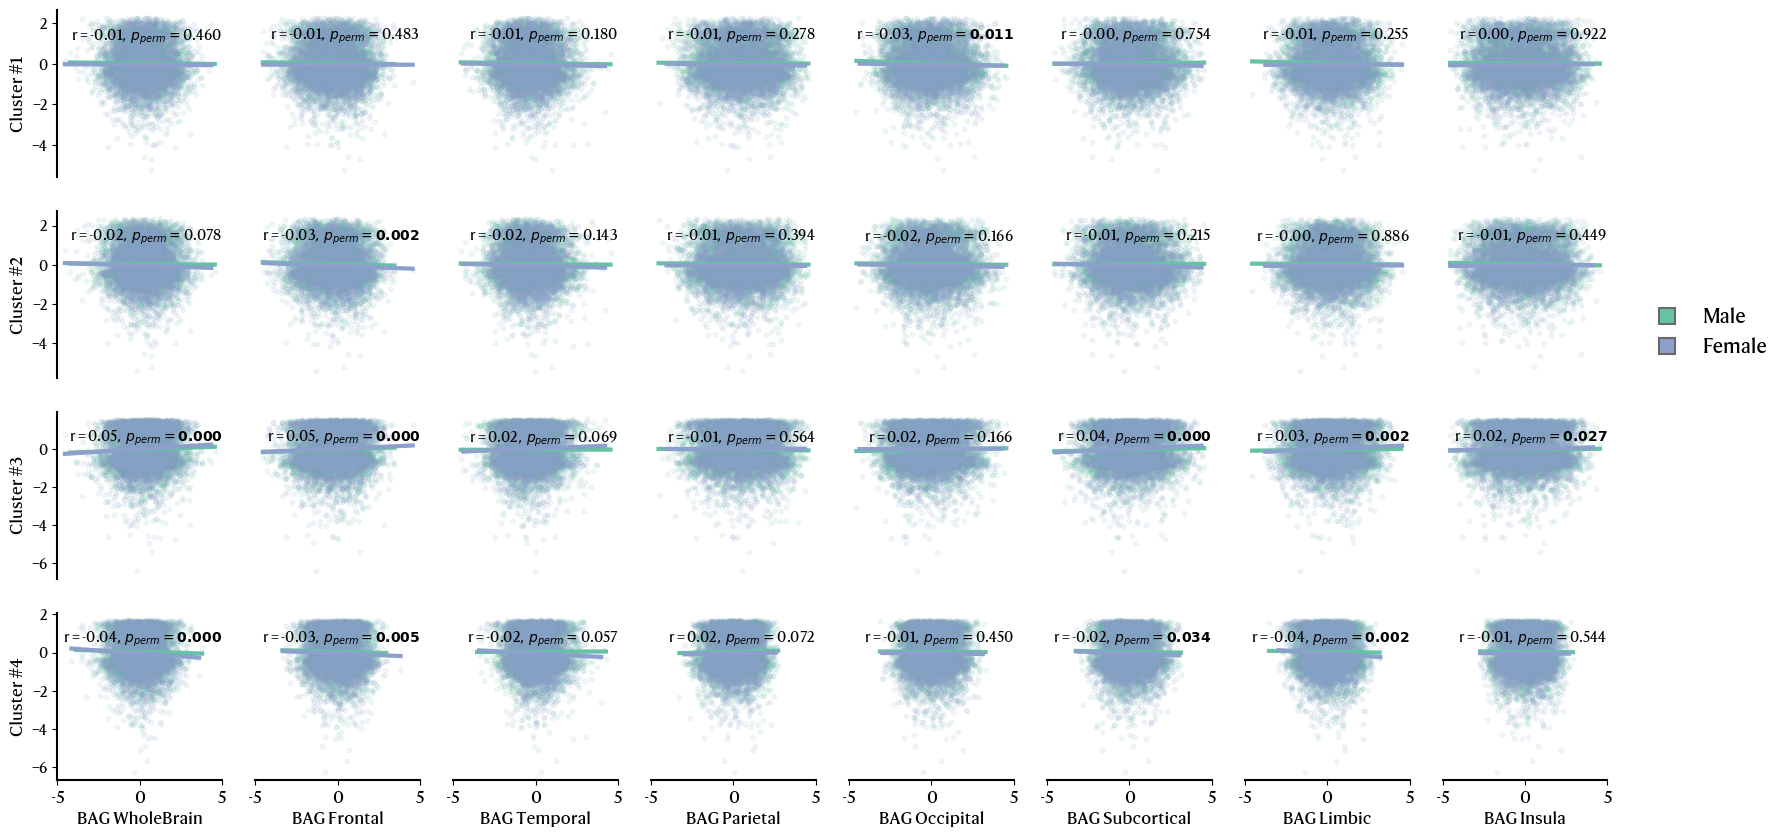

In [103]:
# Plot results by doing a scatterplot between BAG and the profiles.
fig, axs = plt.subplots(4, 8, figsize=(20, 10), sharey=False)
for i, region in tqdm(enumerate(regions), desc="Plotting data"):
    for j, col in enumerate(profiles):

        male = df[df["sex"] == 1]
        female = df[df["sex"] == 2]

        sns.regplot(data=male, x=region + "_residuals", y=col + "_log", ax=axs[j, i], color=cmap[0], ci=95,
                    scatter=True, 
                    scatter_kws={"s": 10, "color": cmap[0], "alpha": 0.10}, line_kws={"color": cmap[0], "linewidth": 3})
        sns.regplot(data=female, x=region + "_residuals", y=col + "_log", ax=axs[j, i], color=cmap[2], ci=95,
                    scatter=True, 
                    scatter_kws={"s": 10, "color": cmap[2], "alpha": 0.10}, line_kws={"color": cmap[2], "linewidth": 3})
        #axs[j, i].set_xlim(-10, 10)
        #axs[j, i].set_ylim(0, 1)
        axs[j, i].set_xlabel("")
        axs[j, i].spines[["top", "right"]].set_visible(False)
        axs[j, i].set_ylabel("")

        if j < 3:
            axs[j, i].set_xticks([])
            axs[j, i].spines[["bottom"]].set_visible(False)
        else:
            axs[j, i].set_xticks([-5, 0, 5])
            axs[j, i].set_xticklabels([-5, 0, 5], fontsize=12)

            #axs[j, i].set_xticks([])
        #else:
            #axs[j, i].set_xticks([-3, 0, 3])
            #axs[j, i].set_xticklabels([-3, 0, 3], fontsize=12)

            # String "_" from the region name.
            region_lab = region.replace("_", " ")
            axs[j, i].set_xlabel(region_lab, fontsize=12)
            axs[j, i].spines["bottom"].set_linewidth(1.5)
        
        if i == 0:
            axs[j, i].set_ylabel(col, fontsize=12)
            axs[j, i].spines["left"].set_linewidth(1.5)
        else:
            axs[j, i].set_yticks([])
            axs[j, i].spines[["left"]].set_visible(False)
        
        # Write the t-value and p-value on the plot.
        rval = results[(results["Region"] == region) & (results["Profile"] == col)]["Partial Correlation"].values[0]
        pval = results[(results["Region"] == region) & (results["Profile"] == col)]["p-value"].values[0]
        pval_corrected = results[(results["Region"] == region) & (results["Profile"] == col)]["p-value permutated"].values[0]

        if pval_corrected < 0.05:
            pval_corrected_text = r"$p_{perm}=$" + r"$\mathbf{" + f"{pval_corrected:.3f}" + "}$"
        else:
            pval_corrected_text = r"$p_{perm}=$" + f"{pval_corrected:.3f}"

        axs[j, i].text(1, 0.9, f"r = {rval:.2f},  {pval_corrected_text}",
                       ha="right", va="top", fontsize=10, transform=axs[j, i].transAxes)
    
# Add a global legend highlighting the colors for the diagnoses with a border.
handles = [plt.Line2D([0], [0], color=cmap[0], markersize=12, lw=0, marker="s", markeredgewidth=1.5, markeredgecolor='dimgrey'),
           plt.Line2D([0], [0], color=cmap[2], markersize=12, lw=0, marker="s", markeredgewidth=1.5, markeredgecolor='dimgrey')]
labels = ["Male", "Female"]
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.95, 0.6),
           ncol=1, fontsize=14, frameon=False)

plt.savefig(f"{output_dir}/profiles-scatterplots.png", dpi=300, bbox_inches="tight")


### **Sensivity analyses using BAG derived from the male and female only models.**

The next few cells will reuse function defined above for linear regression and permutation testing, but will performed it on the male/female-only BAG values.


In [104]:
# Load the male only dataframe for BAG values.
BAG_df_male = pd.read_csv(f"{output_folder}/BAG_male.csv")

# Load the profiles' dataset.
fcm = pd.read_excel(f"{output_folder}/merged_fcm_data.xlsx")

# remove the "_" from the subjectkey column and append "sub-".
fcm["subjectkey"] = "sub-" + fcm["subjectkey"].str.replace("_", "")
fcm.rename(columns={"subjectkey": "sid"}, inplace=True)

regions = ["BAG_WholeBrain", "BAG_Frontal", "BAG_Temporal", "BAG_Parietal",
           "BAG_Occipital", "BAG_Subcortical", "BAG_Limbic", "BAG_Insula"]
profiles = ["Cluster #1", "Cluster #2", "Cluster #3", "Cluster #4"]

# Keep only the sid, and Cluster columns.
fcm = fcm[["sid"] + profiles]

# Merge on sid
BAG_df_male = BAG_df_male.merge(fcm, on="sid", how="left")

# Print the number of subjects in the merged df.
print(f"Number of subjects in merged df: {BAG_df_male['sid'].nunique()}")
# Drop rows with missing values, only in the fcm columns.
BAG_df_male.dropna(subset=profiles, inplace=True)
# Print the new number of subjects.
print(f"Number of subjects after dropping missing values: {BAG_df_male['sid'].nunique()}")

# Dummy code the sites to a integer.
BAG_df_male["site"] = BAG_df_male["site"].astype("category").cat.codes

# Regress out the covariates.
for i, region in tqdm(enumerate(regions), desc="Regressing out covariates"):

    # Run a linear model and fetch the residuals.
    mod = OLS(
        BAG_df_male[region + "_Corrected"].values,
        sm.add_constant(BAG_df_male[["age", "income_groups", "edu_groups", "Ethnicity", "handedness"]]),
    ).fit()

    BAG_df_male[region + "_residuals"] = scale(mod.resid)

# Log transform the profiles and scale them (mostly for visualization).
for i, profile in tqdm(enumerate(profiles), desc="Log transforming and scaling"):

    # Log transform the profiles.
    BAG_df_male[profile + "_log"] = scale(BAG_df_male[profile].apply(lambda x: np.log(x)))


Number of subjects in merged df: 4722
Number of subjects after dropping missing values: 4358


Regressing out covariates: 8it [00:00, 125.43it/s]
Log transforming and scaling: 4it [00:00, 290.72it/s]


In [105]:
# Run the linear model for all profiles and all BAG.
k = 0

for i, region in enumerate(regions):
    for j, profile in enumerate(profiles):
        # Run the linear model.
        res, t, r, b, pval = run_linear_model(
            df=BAG_df_male,
            X=region + "_Corrected",
            y=profile + "_log",
            covariates=["age", "income_groups", "edu_groups", "Ethnicity", "handedness"]
        )

        # Run the permutation test.
        perm_results = run_permutation_test_parallel(
            df=BAG_df_male,
            X=region + "_Corrected",
            y=profile + "_log",
            covariates=["age", "income_groups", "edu_groups", "Ethnicity", "handedness"],
            n_permutations=10000,
            n_jobs=6
        )

        # Compute the p-value from the permutation test.
        pval_perm = (np.sum(np.abs(perm_results) >= np.abs(r)) + 1) / (len(perm_results) + 1)

        # Append the results to the lists.
        if i == 0 and j == 0:
            results = pd.DataFrame({
                "Region": region,
                "Profile": profile,
                "Coefficient": b,
                "t-statistic": t,
                "Partial Correlation": r,
                "p-value": pval,
                "p-value permutated": pval_perm
            }, index=[k])
        else:
            results = pd.concat([results, pd.DataFrame({
                "Region": region,
                "Profile": profile,
                "Coefficient": b,
                "t-statistic": t,
                "Partial Correlation": r,
                "p-value": pval,
                "p-value permutated": pval_perm
            }, index=[k])]
            , axis=0, ignore_index=True)

        k += 1

# Perform FDR correction on the p-values (per diagnosis).
# Get the p-values for each diagnosis.
#for profile in profiles:
    # Get the p-values for the current diagnosis.
#    pval = results[results["Profile"] == profile]["p-value"].values

    # Perform FDR correction.
#    pval_corrected = false_discovery_control(pval, method="bh")

    # Add the corrected p-values to the results DataFrame.
#    results.loc[results["Profile"] == profile, "p-value corrected"] = pval_corrected

# Save the results to a CSV file.
results.to_csv(f"{output_dir}/BAG_Male_Profiles_results.csv", index=False)


Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:08<00:00, 1149.68it/s]
Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:06<00:00, 1534.99it/s]
Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:05<00:00, 1694.21it/s]
Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:06<00:00, 1519.06it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Frontal_Corrected: 100%|██████████| 10000/10000 [00:05<00:00, 1695.57it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Frontal_Corrected: 100%|██████████| 10000/10000 [00:05<00:00, 1797.87it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Frontal_Corrected: 100%|██████████| 10000/10000 [00:06<00:00, 1538.82it/s]
Running 10000 permutations in parallel for diagnosis: BAG

Plotting data: 8it [00:04,  1.72it/s]


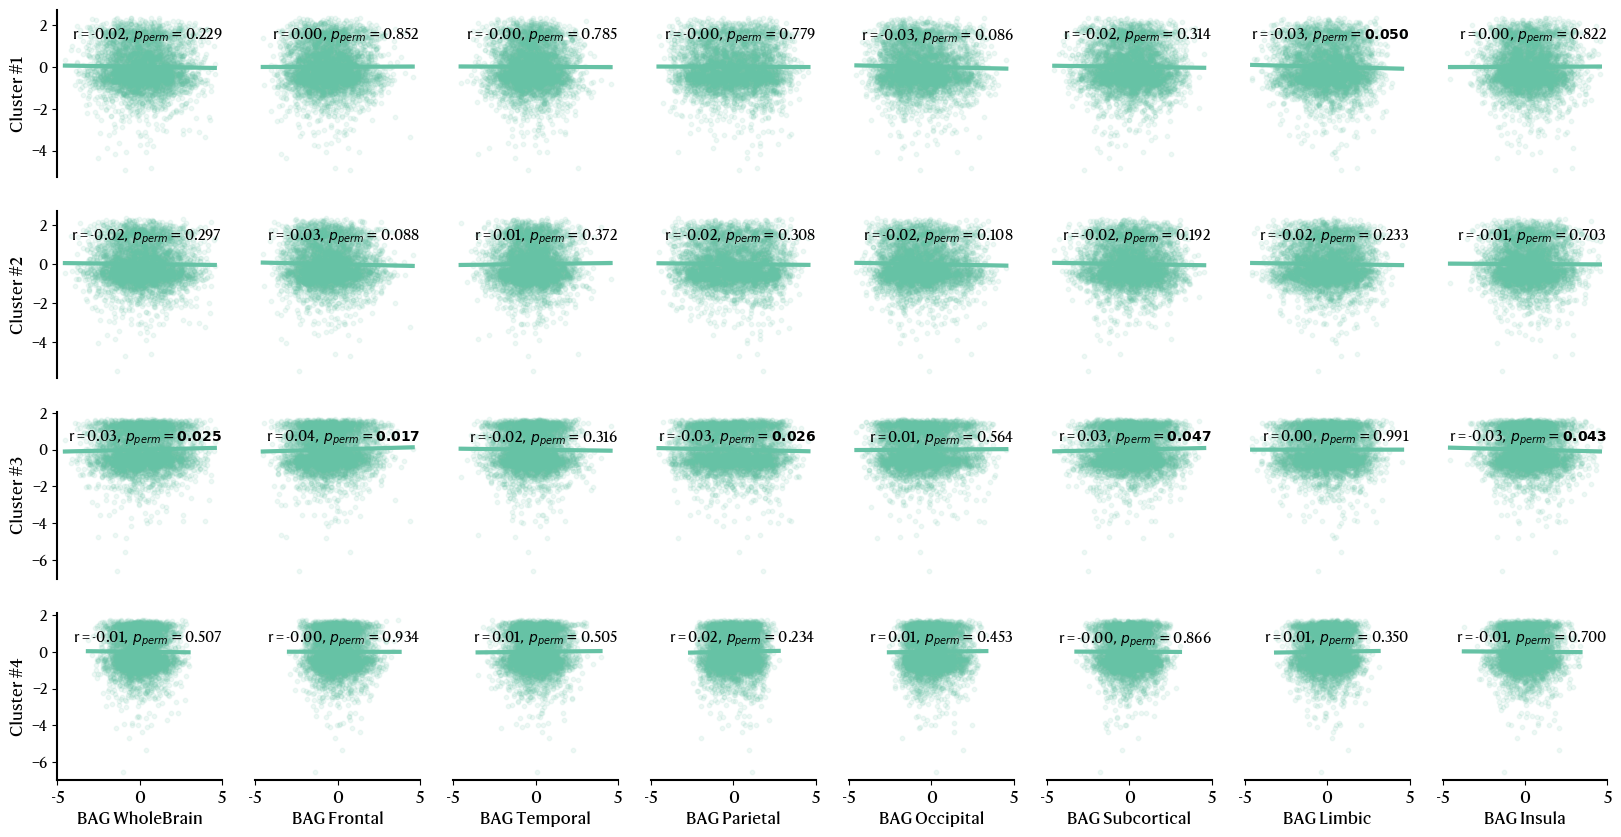

In [106]:
# Plot results by doing a scatterplot between BAG and the profiles.
fig, axs = plt.subplots(4, 8, figsize=(20, 10), sharey=False)
for i, region in tqdm(enumerate(regions), desc="Plotting data"):
    for j, col in enumerate(profiles):

        sns.regplot(data=BAG_df_male, x=region + "_residuals", y=col + "_log", ax=axs[j, i], color=cmap[0], ci=95,
                    scatter=True, 
                    scatter_kws={"s": 10, "color": cmap[0], "alpha": 0.10}, line_kws={"color": cmap[0], "linewidth": 3})
        #axs[j, i].set_xlim(-10, 10)
        #axs[j, i].set_ylim(0, 1)
        axs[j, i].set_xlabel("")
        axs[j, i].spines[["top", "right"]].set_visible(False)
        axs[j, i].set_ylabel("")

        if j < 3:
            axs[j, i].set_xticks([])
            axs[j, i].spines[["bottom"]].set_visible(False)
        else:
            axs[j, i].set_xticks([-5, 0, 5])
            axs[j, i].set_xticklabels([-5, 0, 5], fontsize=12)

            #axs[j, i].set_xticks([])
        #else:
            #axs[j, i].set_xticks([-3, 0, 3])
            #axs[j, i].set_xticklabels([-3, 0, 3], fontsize=12)

            # String "_" from the region name.
            region_lab = region.replace("_", " ")
            axs[j, i].set_xlabel(region_lab, fontsize=12)
            axs[j, i].spines["bottom"].set_linewidth(1.5)
        
        if i == 0:
            axs[j, i].set_ylabel(col, fontsize=12)
            axs[j, i].spines["left"].set_linewidth(1.5)
        else:
            axs[j, i].set_yticks([])
            axs[j, i].spines[["left"]].set_visible(False)
        
        # Write the t-value and p-value on the plot.
        rval = results[(results["Region"] == region) & (results["Profile"] == col)]["Partial Correlation"].values[0]
        pval = results[(results["Region"] == region) & (results["Profile"] == col)]["p-value"].values[0]
        pval_corrected = results[(results["Region"] == region) & (results["Profile"] == col)]["p-value permutated"].values[0]

        if pval_corrected < 0.05:
            pval_corrected_text = r"$p_{perm}=$" + r"$\mathbf{" + f"{pval_corrected:.3f}" + "}$"
        else:
            pval_corrected_text = r"$p_{perm}=$" + f"{pval_corrected:.3f}"

        axs[j, i].text(1, 0.9, f"r = {rval:.2f},  {pval_corrected_text}",
                       ha="right", va="top", fontsize=10, transform=axs[j, i].transAxes)

plt.savefig(f"{output_dir}/profiles-scatterplots-male.png", dpi=300, bbox_inches="tight")


In [107]:
# Load up the female BAG df.
BAG_df_female = pd.read_csv(f"{output_folder}/BAG_female.csv")

# Load the profiles' dataset.
fcm = pd.read_excel(f"{output_folder}/merged_fcm_data.xlsx")

# remove the "_" from the subjectkey column and append "sub-".
fcm["subjectkey"] = "sub-" + fcm["subjectkey"].str.replace("_", "")
fcm.rename(columns={"subjectkey": "sid"}, inplace=True)

regions = ["BAG_WholeBrain", "BAG_Frontal", "BAG_Temporal", "BAG_Parietal",
           "BAG_Occipital", "BAG_Subcortical", "BAG_Limbic", "BAG_Insula"]
profiles = ["Cluster #1", "Cluster #2", "Cluster #3", "Cluster #4"]

# Keep only the sid, and Cluster columns.
fcm = fcm[["sid"] + profiles]

# Merge on sid
BAG_df_female = BAG_df_female.merge(fcm, on="sid", how="left")

# Print the number of subjects in the merged df.
print(f"Number of subjects in merged df: {BAG_df_female['sid'].nunique()}")
# Drop rows with missing values, only in the fcm columns.
BAG_df_female.dropna(subset=profiles, inplace=True)
# Print the new number of subjects.
print(f"Number of subjects after dropping missing values: {BAG_df_female['sid'].nunique()}")

# Dummy code the sites to a integer.
BAG_df_female["site"] = BAG_df_female["site"].astype("category").cat.codes

# Regress out the covariates.
for i, region in tqdm(enumerate(regions), desc="Regressing out covariates"):

    # Run a linear model and fetch the residuals.
    mod = OLS(
        BAG_df_female[region + "_Corrected"].values,
        sm.add_constant(BAG_df_female[["age", "income_groups", "edu_groups", "Ethnicity", "handedness"]]),
    ).fit()

    BAG_df_female[region + "_residuals"] = scale(mod.resid)

# Log transform the profiles and scale them (mostly for visualization).
for i, profile in tqdm(enumerate(profiles), desc="Log transforming and scaling"):

    # Log transform the profiles.
    BAG_df_female[profile + "_log"] = scale(BAG_df_female[profile].apply(lambda x: np.log(x)))

Number of subjects in merged df: 4352
Number of subjects after dropping missing values: 4003


Regressing out covariates: 8it [00:00, 156.75it/s]
Log transforming and scaling: 4it [00:00, 213.37it/s]


In [108]:
# Run the linear model for all profiles and all BAG.
k = 0

for i, region in enumerate(regions):
    for j, profile in enumerate(profiles):
        # Run the linear model.
        res, t, r, b, pval = run_linear_model(
            df=BAG_df_female,
            X=region + "_Corrected",
            y=profile + "_log",
            covariates=["age", "income_groups", "edu_groups", "Ethnicity", "handedness"]
        )

        # Run the permutation test.
        perm_results = run_permutation_test_parallel(
            df=BAG_df_female,
            X=region + "_Corrected",
            y=profile + "_log",
            covariates=["age", "income_groups", "edu_groups", "Ethnicity", "handedness"],
            n_permutations=10000,
            n_jobs=6
        )

        # Compute the p-value from the permutation test.
        pval_perm = (np.sum(np.abs(perm_results) >= np.abs(r)) + 1) / (len(perm_results) + 1)

        # Append the results to the lists.
        if i == 0 and j == 0:
            results = pd.DataFrame({
                "Region": region,
                "Profile": profile,
                "Coefficient": b,
                "t-statistic": t,
                "Partial Correlation": r,
                "p-value": pval,
                "p-value permutated": pval_perm
            }, index=[k])
        else:
            results = pd.concat([results, pd.DataFrame({
                "Region": region,
                "Profile": profile,
                "Coefficient": b,
                "t-statistic": t,
                "Partial Correlation": r,
                "p-value": pval,
                "p-value permutated": pval_perm
            }, index=[k])]
            , axis=0, ignore_index=True)

        k += 1

# Perform FDR correction on the p-values (per diagnosis).
# Get the p-values for each diagnosis.
#for profile in profiles:
    # Get the p-values for the current diagnosis.
#    pval = results[results["Profile"] == profile]["p-value"].values

    # Perform FDR correction.
#    pval_corrected = false_discovery_control(pval, method="bh")

    # Add the corrected p-values to the results DataFrame.
#    results.loc[results["Profile"] == profile, "p-value corrected"] = pval_corrected

# Save the results to a CSV file.
results.to_csv(f"{output_dir}/BAG_Female_Profiles_results.csv", index=False)


Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:17<00:00, 559.91it/s]
Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:05<00:00, 1967.52it/s]
Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:07<00:00, 1416.34it/s]
Running 10000 permutations in parallel for diagnosis: BAG_WholeBrain_Corrected: 100%|██████████| 10000/10000 [00:05<00:00, 1754.39it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Frontal_Corrected: 100%|██████████| 10000/10000 [00:04<00:00, 2113.60it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Frontal_Corrected: 100%|██████████| 10000/10000 [00:06<00:00, 1615.53it/s]
Running 10000 permutations in parallel for diagnosis: BAG_Frontal_Corrected: 100%|██████████| 10000/10000 [00:07<00:00, 1385.93it/s]
Running 10000 permutations in parallel for diagnosis: BAG_

Plotting data: 8it [00:04,  1.94it/s]


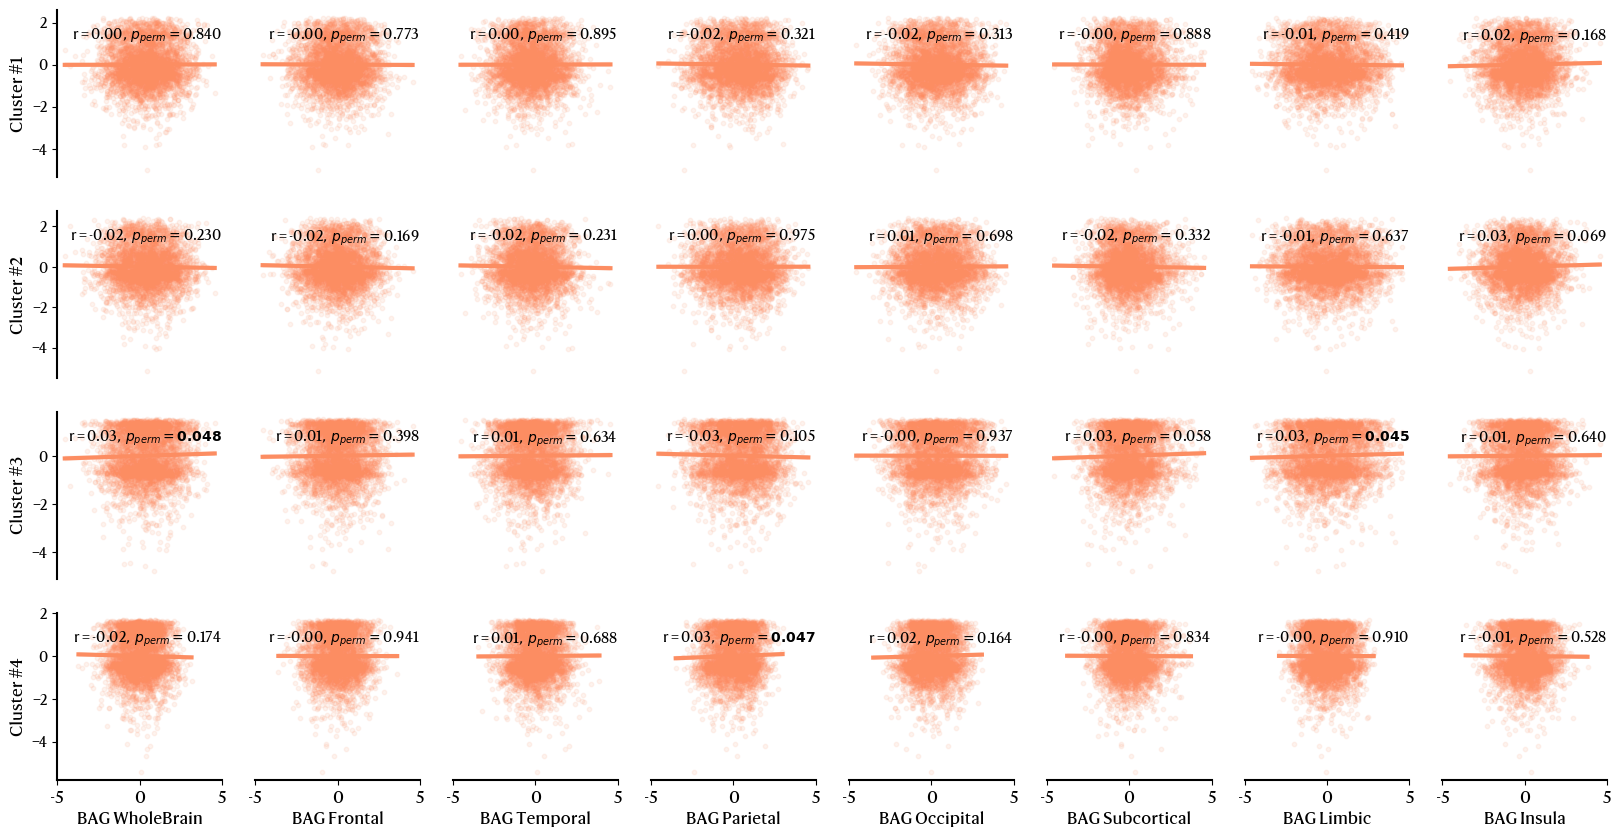

In [109]:
# Plot results by doing a scatterplot between BAG and the profiles.
fig, axs = plt.subplots(4, 8, figsize=(20, 10), sharey=False)
for i, region in tqdm(enumerate(regions), desc="Plotting data"):
    for j, col in enumerate(profiles):

        sns.regplot(data=BAG_df_female, x=region + "_residuals", y=col + "_log", ax=axs[j, i], color=cmap[1], ci=95,
                    scatter=True, 
                    scatter_kws={"s": 10, "color": cmap[1], "alpha": 0.10}, line_kws={"color": cmap[1], "linewidth": 3})
        #axs[j, i].set_xlim(-10, 10)
        #axs[j, i].set_ylim(0, 1)
        axs[j, i].set_xlabel("")
        axs[j, i].spines[["top", "right"]].set_visible(False)
        axs[j, i].set_ylabel("")

        if j < 3:
            axs[j, i].set_xticks([])
            axs[j, i].spines[["bottom"]].set_visible(False)
        else:
            axs[j, i].set_xticks([-5, 0, 5])
            axs[j, i].set_xticklabels([-5, 0, 5], fontsize=12)

            #axs[j, i].set_xticks([])
        #else:
            #axs[j, i].set_xticks([-3, 0, 3])
            #axs[j, i].set_xticklabels([-3, 0, 3], fontsize=12)

            # String "_" from the region name.
            region_lab = region.replace("_", " ")
            axs[j, i].set_xlabel(region_lab, fontsize=12)
            axs[j, i].spines["bottom"].set_linewidth(1.5)
        
        if i == 0:
            axs[j, i].set_ylabel(col, fontsize=12)
            axs[j, i].spines["left"].set_linewidth(1.5)
        else:
            axs[j, i].set_yticks([])
            axs[j, i].spines[["left"]].set_visible(False)
        
        # Write the t-value and p-value on the plot.
        rval = results[(results["Region"] == region) & (results["Profile"] == col)]["Partial Correlation"].values[0]
        pval = results[(results["Region"] == region) & (results["Profile"] == col)]["p-value"].values[0]
        pval_corrected = results[(results["Region"] == region) & (results["Profile"] == col)]["p-value permutated"].values[0]

        if pval_corrected < 0.05:
            pval_corrected_text = r"$p_{perm}=$" + r"$\mathbf{" + f"{pval_corrected:.3f}" + "}$"
        else:
            pval_corrected_text = r"$p_{perm}=$" + f"{pval_corrected:.3f}"

        axs[j, i].text(1, 0.9, f"r = {rval:.2f},  {pval_corrected_text}",
                       ha="right", va="top", fontsize=10, transform=axs[j, i].transAxes)

plt.savefig(f"{output_dir}/profiles-scatterplots-female.png", dpi=300, bbox_inches="tight")


#### **Load back the results to apply multiple comparison**

Since we performed a few statistical tests, we need to apply multiple comparison correction.

In [4]:
# Load back the results.
results = pd.read_csv(f"{output_dir}/BAG_Profiles_results.csv")
results_f = pd.read_csv(f"{output_dir}/BAG_Female_Profiles_results.csv")
results_m = pd.read_csv(f"{output_dir}/BAG_Male_Profiles_results.csv")

In [8]:
# Apply multiple correction using the fdr_tsbky from statsmodel.
profiles = ["Cluster #1", "Cluster #2", "Cluster #3", "Cluster #4"]

# Iterate over dx to apply correction on p-value permuted.
for p in profiles:
    pvals = results.loc[results["Profile"] == p, "p-value permutated"].values
    results.loc[results["Profile"] == p, "p-value permuted corrected"] = multipletests(pvals, alpha=0.05, method="fdr_tsbh")[1]

    pvals_f = results_f.loc[results_f["Profile"] == p, "p-value permutated"].values
    results_f.loc[results_f["Profile"] == p, "p-value permuted corrected"] = multipletests(pvals_f, alpha=0.05, method="fdr_tsbh")[1]

    pvals_m = results_m.loc[results_m["Profile"] == p, "p-value permutated"].values
    results_m.loc[results_m["Profile"] == p, "p-value permuted corrected"] = multipletests(pvals_m, alpha=0.05, method="fdr_tsbh")[1]

# Optionally save corrected results
results.to_csv(f"{output_dir}/BAG_Profiles_results_fdr_tsbh.csv", index=False)
results_f.to_csv(f"{output_dir}/BAG_Female_Profiles_results_fdr_tsbh.csv", index=False)
results_m.to_csv(f"{output_dir}/BAG_Male_Profiles_results_fdr_tsbh.csv", index=False)